# Emotion From Text Detection
Project for Course COMP6576001 Natural Language Processing

Members:
- 2440017126 - Vio Albert Ferdinand
- 2440062161 - Francis Alexander
- 2440062155 - Edwin Ario Abdiwijaya

References:
-  https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

## Preparation

In [440]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [441]:
train_data = pd.read_csv('train.txt', sep=';', names=['sentence', 'emotion'], encoding='utf-8')
val_data = pd.read_csv('val.txt', sep=';', names=['sentence', 'emotion'], encoding='utf-8')
test_data = pd.read_csv('test.txt', sep=';', names=['sentence', 'emotion'], encoding='utf-8')

In [442]:
# biar bisa dilooping kalau perlu
all_data = {
  "train": train_data,
  "val": val_data,
  "test": test_data
}

In [443]:
for key, data in all_data.items():
  print(key, ":")
  print(data.head())
  print()
  print(data.tail())

train :
                                            sentence  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

                                                sentence  emotion
15995  i just had a very brief time in the beanbag an...  sadness
15996  i am now turning and i feel pathetic that i am...  sadness
15997                     i feel strong and good overall      joy
15998  i feel like this was such a rude comment and i...    anger
15999  i know a lot but i feel so stupid because i ca...  sadness
val :
                                            sentence  emotion
0  im feeling quite sad and sorry for myself but ...  sadness
1  i feel like i am still looking at a blank canv...  sadness
2                     i feel li

## Data Analysis

Cek shape

In [444]:
for key, data in all_data.items():
  print(key, ":")
  print(data.shape)
  print()

train :
(16000, 2)

val :
(2000, 2)

test :
(2000, 2)



In [445]:
for key, data in all_data.items():
  print(key, ":")
  print(data['emotion'].value_counts())
  print()

train :
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64

val :
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: emotion, dtype: int64

test :
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: emotion, dtype: int64



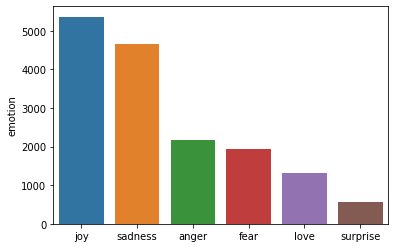

In [446]:
sns.barplot(x=train_data.emotion.value_counts().index,y=train_data.emotion.value_counts())
plt.show()

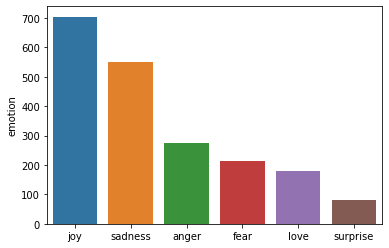

In [447]:
sns.barplot(x=val_data.emotion.value_counts().index,y=val_data.emotion.value_counts())
plt.show()

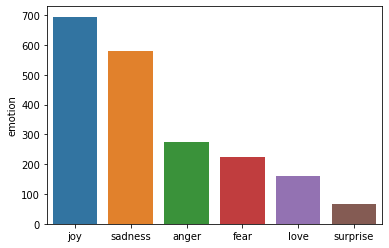

In [448]:
sns.barplot(x=test_data.emotion.value_counts().index,y=test_data.emotion.value_counts())
plt.show()

In [449]:
all_data['train'][all_data['train']['emotion'] == 'joy'].head()

,sentence,emotion
8,i have been with petronas for years i feel tha...,joy
11,i do feel that running is a divine experience ...,joy
14,i have immense sympathy with the general point...,joy
15,i do not feel reassured anxiety is on each side,joy
22,i have the feeling she was amused and delighted,joy


In [450]:
all_data['train'][all_data['train']['emotion'] == 'sadness'].head()

,sentence,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
5,ive been feeling a little burdened lately wasn...,sadness
10,i feel like i have to make the suffering i m s...,sadness
13,i feel low energy i m just thirsty,sadness


In [451]:
all_data['train'][all_data['train']['emotion'] == 'anger'].head()

,sentence,emotion
2,im grabbing a minute to post i feel greedy wrong,anger
4,i am feeling grouchy,anger
12,i think it s the easiest time of year to feel ...,anger
20,i feel irritated and rejected without anyone d...,anger
24,i already feel like i fucked up though because...,anger


In [452]:
all_data['train'][all_data['train']['emotion'] == 'fear'].head()

,sentence,emotion
7,i feel as confused about life as a teenager or...,fear
19,i now feel compromised and skeptical of the va...,fear
21,i am feeling completely overwhelmed i have two...,fear
31,i remember feeling acutely distressed for a fe...,fear
53,i was stymied a little bit as i wrote feeling ...,fear


In [453]:
all_data['train'][all_data['train']['emotion'] == 'love'].head()

,sentence,emotion
3,i am ever feeling nostalgic about the fireplac...,love
9,i feel romantic too,love
47,i can t let go of that sad feeling that i want...,love
61,i ate i could feel a gentle tingle throughout ...,love
68,i suppose my own truth needs to be shared i ha...,love


In [454]:
all_data['train'][all_data['train']['emotion'] == 'surprise'].head()

,sentence,emotion
6,ive been taking or milligrams or times recomme...,surprise
32,i have seen heard and read over the past coupl...,surprise
57,i keep feeling pleasantly surprised at his sup...,surprise
64,i am now nearly finished the week detox and i ...,surprise
129,i too feel as if i am a stranger in a strange ...,surprise


Cek null

In [455]:
for key, data in all_data.items():
  print(key, ":")
  print(data.isnull().sum())
  print()

train :
sentence    0
emotion     0
dtype: int64

val :
sentence    0
emotion     0
dtype: int64

test :
sentence    0
emotion     0
dtype: int64



Cek Duplicate 

In [456]:
for key, data in all_data.items():
  print(key, ":")
  print(data.duplicated().value_counts())
  print()

train :
False    15999
True         1
dtype: int64

val :
False    2000
dtype: int64

test :
False    2000
dtype: int64



In [457]:
all_data['train'][all_data['train'].duplicated()]

,sentence,emotion
13846,i feel more adventurous willing to take risks ...,joy


Kalo ada yg duplicate, drop

In [458]:
for key, data in all_data.items():
  data = data.drop_duplicates(inplace=True)

In [459]:
# aku gatau kenapa kalo gini ga ke reset indexnya tapi kalo 1 1 bisa..
# for key, data in all_data.items():
#   data = data.reset_index(drop=True)

all_data['train']=all_data['train'].reset_index(drop=True)

In [460]:
all_data['train']['sentence'][13846]

'i feel god can be humorous and creative and just so awesome'

In [461]:
for key, data in all_data.items():
  print(key, ":")
  print(data.duplicated().value_counts())
  print()

train :
False    15999
dtype: int64

val :
False    2000
dtype: int64

test :
False    2000
dtype: int64



In [462]:
for key, data in all_data.items():
  print(key, ":")
  print(data.shape)
  print()

train :
(15999, 2)

val :
(2000, 2)

test :
(2000, 2)



## Preprocessing


*   Ubah singkatan - singkatan yang kek won't wouldn't (Decontracted)
*   Buang kata - kata yang gaada artinya (http, url,dkk)
*   Spelling check
*   Pake stopwords?





Contraction

In [463]:
!pip install contractions
import contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [464]:
# remove contractions
arr = []
for key, data in all_data.items():
  kalimat = []
  for sentence in data['sentence']:
    expanded_word = []
    for word in sentence.split():
      expanded_word.append(contractions.fix(word))
      expanded = ' '.join(expanded_word)
    kalimat.append(expanded)
  arr.append(kalimat)

In [465]:
all_data['train']["sentence"] = pd.DataFrame(arr[0],columns={"sentence"})
all_data['val']["sentence"] = pd.DataFrame(arr[1],columns={"sentence"})
all_data['test']["sentence"] = pd.DataFrame(arr[2],columns={"sentence"})

### Data Cleaning

In [466]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet

tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
  """Map POS tag to first character lemmatize() accepts"""
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}
  return tag_dict.get(tag, wordnet.NOUN)

def yukTokenize(kalimat):
  tokenized = ' '.join(w.lower() for w in tokenizer.tokenize(kalimat))
  return tokenized

def yukDecontract(kalimat):
  kalimat = re.sub(r"n t "," not ",kalimat)
  kalimat = re.sub(r"\bre\b","are",kalimat)
  kalimat = re.sub(r"\bs\b","is",kalimat)
  kalimat = re.sub(r"\bd\b","would",kalimat)
  kalimat = re.sub(r"\bll\b","will",kalimat)
  kalimat = re.sub(r"\bve\b","have",kalimat)
  kalimat = re.sub(r"\bm\b","am",kalimat)
  kalimat = re.sub(r"\bw\b","not",kalimat)
  kalimat = re.sub(r"\bdunno\b","do not know",kalimat)
  return kalimat

def yukLemmatize(sentence):
  lemmatized_word = []
  for word in sentence.split():
    lemmatized_word.append(lemmatizer.lemmatize(word, get_wordnet_pos(word)))
  lemmatized = ' '.join(lemmatized_word)
  return lemmatized

def yukDecontractPakaiLibrary(sentence):
  expanded_word = []
  for word in sentence.split():
    expanded_word.append(contractions.fix(word))
  expanded = ' '.join(expanded_word)
  return expanded

def yukBersihin(sentence):
  sentence = yukTokenize(sentence)
  sentence = yukDecontractPakaiLibrary(sentence)
  sentence = yukDecontract(sentence)
  sentence = yukLemmatize(sentence)
  sentence = re.sub(r" url ","",sentence)
  sentence = re.sub(r" fn ","",sentence)
  sentence = re.sub(r" n ","",sentence)
  sentence = re.sub(r" href ","",sentence)
  sentence = re.sub(r" http ","",sentence)
  sentence = re.sub(r" www ","",sentence)
  return sentence

def yukBersihinDF(df):
  cleaned=[]
  for sentence in df["sentence"]:
    cleaned.append(yukBersihin(sentence))
  return cleaned

In [467]:
all_data['train'].head()

,sentence,emotion
0,i did not feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,i am grabbing a minute to post i feel greedy w...,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [468]:
all_data['train']["sentence"] = all_data['train']["sentence"].apply(yukBersihin)
all_data['val']["sentence"] = all_data['val']["sentence"].apply(yukBersihin)
all_data['test']["sentence"] = all_data['test']["sentence"].apply(yukBersihin)

# all_data['train']["sentence"] = yukBersihinDF(all_data['train'])
# all_data['val']["sentence"] = yukBersihinDF(all_data['val'])
# all_data['test']["sentence"] = yukBersihinDF(all_data['test'])

In [469]:
all_data['train'].head()

,sentence,emotion
0,i do not feel humiliate,sadness
1,i can go from feel so hopeless to so damn hope...,sadness
2,i be grab a minute to post i feel greedy wrong,anger
3,i be ever feel nostalgic about the fireplace i...,love
4,i be feel grouchy,anger


In [470]:
#ini kalo mw ngeliat apa aja yg contraction ganti ganti aja kalimatnya biar bisa tau butuh nambah contractions apa aja
sentence = "im usually like sam but sometimes he gets downright whiny and i ll admit that all the mistakes he made due to sibling rivalry and pride that eventually led to the end of season kind of made me feel less tragic about the whole thing"

# expanded_word = []
# for word in sentence.split():
#   expanded_word.append(contractions.fix(word))
# expanded = ' '.join(expanded_word)

expanded = yukBersihin(sentence)

print(sentence)
print(expanded)

im usually like sam but sometimes he gets downright whiny and i ll admit that all the mistakes he made due to sibling rivalry and pride that eventually led to the end of season kind of made me feel less tragic about the whole thing
i be usually like sam but sometimes he get downright whiny and i will admit that all the mistake he make due to sibling rivalry and pride that eventually lead to the end of season kind of make me feel less tragic about the whole thing


### Laber Encoder

In [471]:
from sklearn.preprocessing import LabelEncoder

labeler = LabelEncoder()

for key, data in all_data.items():
  data['label'] = labeler.fit_transform(data['emotion'])

all_data['train'][['emotion', 'label']].drop_duplicates(keep='first').sort_values('label')

,emotion,label
2,anger,0
7,fear,1
8,joy,2
3,love,3
0,sadness,4
6,surprise,5


In [472]:
all_data['train'].head()

,sentence,emotion,label
0,i do not feel humiliate,sadness,4
1,i can go from feel so hopeless to so damn hope...,sadness,4
2,i be grab a minute to post i feel greedy wrong,anger,0
3,i be ever feel nostalgic about the fireplace i...,love,3
4,i be feel grouchy,anger,0


In [473]:
all_data['val'].head()

,sentence,emotion,label
0,i be feel quite sad and sorry for myself but i...,sadness,4
1,i feel like i be still look at a blank canvas ...,sadness,4
2,i feel like a faithful servant,love,3
3,i be just feel cranky and blue,anger,0
4,i can have for a treat or if i be feel festive,joy,2


In [474]:
all_data['test'].head()

,sentence,emotion,label
0,i be feel rather rotten so i be not very ambit...,sadness,4
1,i be update my blog because i feel shitty,sadness,4
2,i never make her separate from me because i do...,sadness,4
3,i left with my bouquet of red and yellow tulip...,joy,2
4,i be feel a little vain when i do this one,sadness,4


### TF-IDF

In [475]:
# define stopwords
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))
excluded = {'cannot', 'hardly', 'lack', 'lacking', 'lacks', 'neither' 'no', 'not', 'nor', 'never', 'none', 'nothing', 'nowhere', 'without'}

stopwords -= excluded

print(stopwords)
print(len(stopwords))

{'will', "mightn't", 'once', 'o', 'him', 'haven', 'do', "hasn't", 'of', 'd', 'were', 'aren', "you've", "needn't", 'doesn', "isn't", 'if', 'when', 'because', 'an', 'it', "couldn't", 'ma', 'further', 'theirs', 'themselves', 'only', 'here', 'weren', "weren't", 'above', 'but', "shan't", 't', 'hadn', 'shan', 'whom', 'few', 'through', 'both', 'so', "she's", 've', "should've", 'down', 'don', 'did', 'his', 'didn', 'all', "you'd", 'they', 'than', 'after', 'into', 'now', 'which', 'what', 'these', 'on', 'the', 'yourself', 'then', 'between', 'up', 'too', 'more', 'mightn', 'for', "that'll", 'about', 'same', 'your', 'her', 'does', 'most', 'wasn', 'myself', 'off', 'be', 'why', 'can', 'other', 'a', 'been', 'll', 'ourselves', 'he', 'to', "won't", 'herself', 'over', 'there', 'how', 'own', "aren't", 'yourselves', 'had', 'needn', 'against', 'himself', 'those', 'me', 'was', 'i', 'isn', 'below', 'at', 'them', 'hasn', 'ain', 'should', 'ours', 'being', 'yours', 'have', 'under', 'y', 'some', "wouldn't", 'durin

In [476]:
from sklearn.feature_extraction.text import TfidfVectorizer
# coba2, max_feature 2500 mayan bagus

# tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=2500, stop_words='english',norm='l2',analyzer='word',
#                         sublinear_tf=True)
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=10, norm='l2', analyzer='word', stop_words=stopwords,
                        sublinear_tf=True)
vectorized_train = tfidf.fit_transform(all_data['train']['sentence'])
print('Number of features:', vectorized_train.shape[1])

Number of features: 2649


In [477]:
# save model svm
pickle_out = open("tfidf.pkl","wb")
pickle.dump(tfidf, pickle_out)
pickle_out.close()

In [478]:
X_train = pd.DataFrame(vectorized_train.toarray()) # mengubah array vector menjadi dataframe
X_train.columns = tfidf.get_feature_names_out() # mendapatkan nama-nama feature untuk menjadi nama kolom
X_train

,abandon,ability,able,absolutely,abuse,accept,acceptable,accepted,accident,accomplish,...,year feel,year old,yell,yes,yesterday,yet,yet feel,yoga,young,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [479]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
abandon,15999.0,0.000350,0.013345,0.0,0.0,0.0,0.0,0.721275
ability,15999.0,0.000831,0.017460,0.0,0.0,0.0,0.0,0.513391
able,15999.0,0.003003,0.029717,0.0,0.0,0.0,0.0,0.533172
absolutely,15999.0,0.001446,0.023689,0.0,0.0,0.0,0.0,0.620427
abuse,15999.0,0.001208,0.023584,0.0,0.0,0.0,0.0,0.845942
...,...,...,...,...,...,...,...,...
yet,15999.0,0.002793,0.029557,0.0,0.0,0.0,0.0,0.636507
yet feel,15999.0,0.000398,0.012811,0.0,0.0,0.0,0.0,0.570826
yoga,15999.0,0.000326,0.011744,0.0,0.0,0.0,0.0,0.562797
young,15999.0,0.001157,0.019702,0.0,0.0,0.0,0.0,0.496756


In [480]:
y_train = all_data['train']['label']
y_train

0        4
1        4
2        0
3        3
4        0
        ..
15994    4
15995    4
15996    2
15997    0
15998    4
Name: label, Length: 15999, dtype: int64

In [481]:
vectorized_val = tfidf.transform(all_data['val']['sentence'])
X_val = pd.DataFrame(vectorized_val.toarray())
X_val.columns = tfidf.get_feature_names_out()
X_val

,abandon,ability,able,absolutely,abuse,accept,acceptable,accepted,accident,accomplish,...,year feel,year old,yell,yes,yesterday,yet,yet feel,yoga,young,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [482]:
X_val.describe().T

,count,mean,std,min,25%,50%,75%,max
abandon,2000.0,0.000445,0.014099,0.0,0.0,0.0,0.0,0.471398
ability,2000.0,0.000232,0.010374,0.0,0.0,0.0,0.0,0.463922
able,2000.0,0.003510,0.034354,0.0,0.0,0.0,0.0,0.614298
absolutely,2000.0,0.000701,0.015744,0.0,0.0,0.0,0.0,0.414294
abuse,2000.0,0.001696,0.029515,0.0,0.0,0.0,0.0,0.706127
...,...,...,...,...,...,...,...,...
yet,2000.0,0.002791,0.029293,0.0,0.0,0.0,0.0,0.454784
yet feel,2000.0,0.000665,0.017204,0.0,0.0,0.0,0.0,0.485963
yoga,2000.0,0.000673,0.017569,0.0,0.0,0.0,0.0,0.542986
young,2000.0,0.002090,0.027629,0.0,0.0,0.0,0.0,0.505004


In [483]:
y_val = all_data['val']['label']
y_val

0       4
1       4
2       3
3       0
4       2
       ..
1995    4
1996    2
1997    2
1998    2
1999    2
Name: label, Length: 2000, dtype: int64

In [484]:
vectorized_test = tfidf.transform(all_data['test']['sentence'])
X_test = pd.DataFrame(vectorized_test.toarray())
X_test.columns = tfidf.get_feature_names_out()
X_test

,abandon,ability,able,absolutely,abuse,accept,acceptable,accepted,accident,accomplish,...,year feel,year old,yell,yes,yesterday,yet,yet feel,yoga,young,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [485]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
abandon,2000.0,0.000806,0.018323,0.0,0.0,0.0,0.0,0.490993
ability,2000.0,0.000789,0.018191,0.0,0.0,0.0,0.0,0.557522
able,2000.0,0.003129,0.029875,0.0,0.0,0.0,0.0,0.467150
absolutely,2000.0,0.001511,0.023518,0.0,0.0,0.0,0.0,0.589672
abuse,2000.0,0.000698,0.015717,0.0,0.0,0.0,0.0,0.395245
...,...,...,...,...,...,...,...,...
yet,2000.0,0.001416,0.019387,0.0,0.0,0.0,0.0,0.373399
yet feel,2000.0,0.000166,0.007440,0.0,0.0,0.0,0.0,0.332733
yoga,2000.0,0.000764,0.019862,0.0,0.0,0.0,0.0,0.590300
young,2000.0,0.002372,0.028668,0.0,0.0,0.0,0.0,0.456638


In [486]:
y_test = all_data['test']['label']
y_test

0       4
1       4
2       4
3       2
4       4
       ..
1995    0
1996    0
1997    2
1998    2
1999    1
Name: label, Length: 2000, dtype: int64

## Modeling

In [487]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV

### Naive Bayes

In [488]:
clf = MultinomialNB()

clf.fit(X_train, y_train)

# save model naive
pickle_out = open("naive-model.pkl","wb")
pickle.dump(clf, pickle_out)
pickle_out.close()

Validation Score:
              precision    recall  f1-score   support

           0       0.94      0.77      0.84       275
           1       0.88      0.72      0.79       212
           2       0.80      0.97      0.87       704
           3       0.97      0.44      0.60       178
           4       0.82      0.95      0.88       550
           5       0.96      0.28      0.44        81

    accuracy                           0.84      2000
   macro avg       0.90      0.69      0.74      2000
weighted avg       0.85      0.84      0.82      2000



<Figure size 432x288 with 0 Axes>

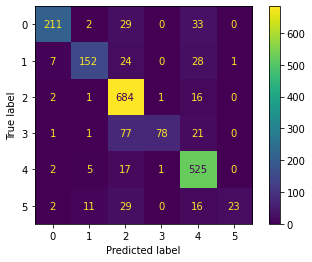

In [489]:
y_pred = clf.predict(X_val)

print("Validation Score:")
print(classification_report(y_val, y_pred))
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.show()

Test Score:
              precision    recall  f1-score   support

           0       0.90      0.71      0.79       275
           1       0.85      0.76      0.80       224
           2       0.80      0.98      0.88       695
           3       0.95      0.39      0.55       159
           4       0.83      0.93      0.87       581
           5       0.92      0.18      0.30        66

    accuracy                           0.83      2000
   macro avg       0.88      0.66      0.70      2000
weighted avg       0.84      0.83      0.81      2000



<Figure size 432x288 with 0 Axes>

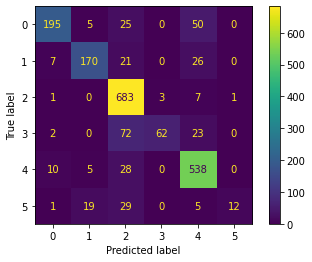

In [490]:
y_pred = clf.predict(X_test)

print("Test Score:")
print(classification_report(y_test, y_pred))
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show() 

### Random Forest

In [491]:
clf = RandomForestClassifier(verbose=2)
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.0min finished


RandomForestClassifier(verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Validation Score:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       275
           1       0.83      0.86      0.85       212
           2       0.89      0.89      0.89       704
           3       0.84      0.72      0.78       178
           4       0.90      0.92      0.91       550
           5       0.80      0.84      0.82        81

    accuracy                           0.88      2000
   macro avg       0.86      0.85      0.85      2000
weighted avg       0.88      0.88      0.88      2000



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


<Figure size 432x288 with 0 Axes>

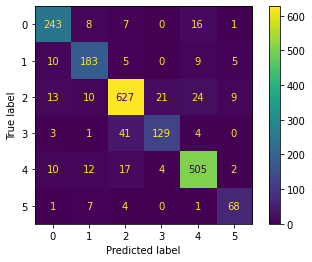

In [492]:
y_pred = clf.predict(X_val)

print("Validation Score:")
print(classification_report(y_val, y_pred))
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.show() 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Test Score:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       275
           1       0.84      0.89      0.87       224
           2       0.88      0.89      0.89       695
           3       0.78      0.64      0.70       159
           4       0.93      0.92      0.92       581
           5       0.61      0.68      0.64        66

    accuracy                           0.87      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.87      0.87      0.87      2000



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


<Figure size 432x288 with 0 Axes>

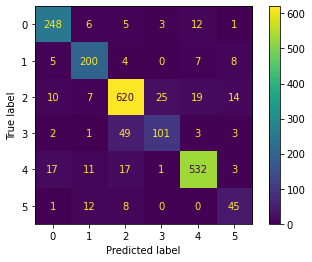

In [493]:
y_pred = clf.predict(X_test)

print("Test Score:")
print(classification_report(y_test, y_pred))
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show() 

### SVM

In [494]:
clf = LinearSVC(random_state=42)

clf.fit(X_train, y_train)

LinearSVC(random_state=42)

In [495]:
# save model svm
pickle_out = open("svm-model.pkl","wb")
pickle.dump(clf, pickle_out)
pickle_out.close()

Validation Score:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       275
           1       0.90      0.85      0.87       212
           2       0.92      0.92      0.92       704
           3       0.81      0.79      0.80       178
           4       0.91      0.94      0.92       550
           5       0.79      0.77      0.78        81

    accuracy                           0.90      2000
   macro avg       0.87      0.86      0.87      2000
weighted avg       0.90      0.90      0.90      2000



<Figure size 432x288 with 0 Axes>

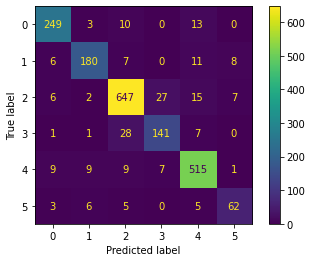

In [496]:
y_pred = clf.predict(X_val)

print("Validation Score:")
print(classification_report(y_val, y_pred))
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.show() 

Test Score:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       275
           1       0.87      0.87      0.87       224
           2       0.90      0.93      0.92       695
           3       0.79      0.71      0.75       159
           4       0.93      0.93      0.93       581
           5       0.73      0.67      0.70        66

    accuracy                           0.89      2000
   macro avg       0.85      0.83      0.84      2000
weighted avg       0.89      0.89      0.89      2000



<Figure size 432x288 with 0 Axes>

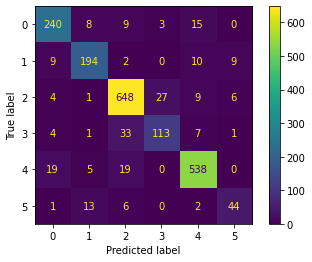

In [497]:
y_pred = clf.predict(X_test)

print("Test Score:")
print(classification_report(y_test, y_pred))
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show() 

### Random Forest (Grid Search)

In [498]:
# RFC_parameter = {'bootstrap': [True],'max_depth': [80, 90, 100, 110],
#                  'min_samples_split': [8, 10, 12]}
# grid_RFC = GridSearchCV(RandomForestClassifier(), RFC_parameter, verbose=2)
# grid_RFC.fit(X_train, y_train)
# RFC = grid_RFC.best_estimator_

In [499]:
# RFC

In [500]:
# y_pred = grid_RFC.predict(X_val)

# print("Validation Score:")
# print(classification_report(y_val, y_pred))
# plt.figure()
# ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
# plt.show()

In [501]:
# y_pred = grid_RFC.predict(X_test)

# print("Test Score:")
# print(classification_report(y_test, y_pred))
# plt.figure()
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
# plt.show() 

### SVM (Grid Search)

In [502]:
SVC_parameter = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid_SVC = GridSearchCV(LinearSVC(random_state=42), SVC_parameter, verbose=2)
grid_SVC.fit(X_train, y_train)
SVC = grid_SVC.best_estimator_

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ............................................C=0.001; total time=   0.4s
[CV] END ............................................C=0.001; total time=   0.4s
[CV] END ............................................C=0.001; total time=   0.4s
[CV] END ............................................C=0.001; total time=   0.4s
[CV] END ............................................C=0.001; total time=   0.4s
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END ..............................................C=0.1; total time=   0.5s
[CV] END ........................................

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[CV] END ..............................................C=100; total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[CV] END ..............................................C=100; total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[CV] END ..............................................C=100; total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[CV] END ..............................................C=100; total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[CV] END ..............................................C=100; total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[CV] END .............................................C=1000; total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[CV] END .............................................C=1000; total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[CV] END .............................................C=1000; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[CV] END .............................................C=1000; total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[CV] END .............................................C=1000; total time=   1.6s


In [503]:
SVC

LinearSVC(C=1, random_state=42)

Validation Score:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       275
           1       0.90      0.85      0.87       212
           2       0.92      0.92      0.92       704
           3       0.81      0.79      0.80       178
           4       0.91      0.94      0.92       550
           5       0.79      0.77      0.78        81

    accuracy                           0.90      2000
   macro avg       0.87      0.86      0.87      2000
weighted avg       0.90      0.90      0.90      2000



<Figure size 432x288 with 0 Axes>

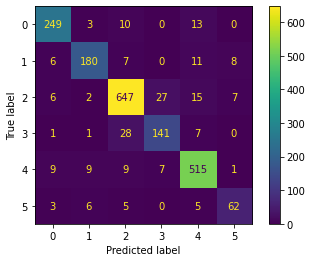

In [504]:
y_pred = grid_SVC.predict(X_val)

print("Validation Score:")
print(classification_report(y_val, y_pred))
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.show()

Test Score:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       275
           1       0.87      0.87      0.87       224
           2       0.90      0.93      0.92       695
           3       0.79      0.71      0.75       159
           4       0.93      0.93      0.93       581
           5       0.73      0.67      0.70        66

    accuracy                           0.89      2000
   macro avg       0.85      0.83      0.84      2000
weighted avg       0.89      0.89      0.89      2000



<Figure size 432x288 with 0 Axes>

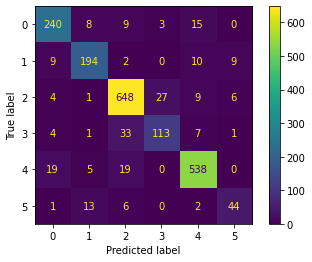

In [505]:
y_pred = grid_SVC.predict(X_test)

print("Test Score:")
print(classification_report(y_test, y_pred))
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show() 